# Ford GoBike Data Exploration

In this notebook, we'll be exploring real trip data from [Ford GoBike](https://www.fordgobike.com/), a public bicycle sharing ("bike share") system in the San Francisco Bay Area, California.

Ford GoBike officially launched on June 28, 2017, and we'll be looking at a full year's worth of trip data starting from that date, all the way through the end of June 2018.

## Preliminary Wrangling

### Gather Data

In [1]:
# Import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

In [2]:
# Load and preview 2017 trip data
df_2017 = pd.read_csv('2017-fordgobike-tripdata.csv')
df_2017.head()

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,member_birth_year,member_gender
0,80110,2017-12-31 16:57:39.6540,2018-01-01 15:12:50.2450,74,Laguna St at Hayes St,37.776435,-122.426244,43,San Francisco Public Library (Grove St at Hyde...,37.778768,-122.415929,96,Customer,1987.0,Male
1,78800,2017-12-31 15:56:34.8420,2018-01-01 13:49:55.6170,284,Yerba Buena Center for the Arts (Howard St at ...,37.784872,-122.400876,96,Dolores St at 15th St,37.766210,-122.426614,88,Customer,1965.0,Female
2,45768,2017-12-31 22:45:48.4110,2018-01-01 11:28:36.8830,245,Downtown Berkeley BART,37.870348,-122.267764,245,Downtown Berkeley BART,37.870348,-122.267764,1094,Customer,NaN,NaN
3,62172,2017-12-31 17:31:10.6360,2018-01-01 10:47:23.5310,60,8th St at Ringold St,37.774520,-122.409449,5,Powell St BART Station (Market St at 5th St),37.783899,-122.408445,2831,Customer,NaN,NaN
4,43603,2017-12-31 14:23:14.0010,2018-01-01 02:29:57.5710,239,Bancroft Way at Telegraph Ave,37.868813,-122.258764,247,Fulton St at Bancroft Way,37.867789,-122.265896,3167,Subscriber,1997.0,Female


In [3]:
# Check dataframe shape and time period
df_2017.shape, df_2017.start_time.min(), df_2017.start_time.max()

((519700, 15), '2017-06-28 09:47:36.3470', '2017-12-31 23:59:01.2610')

We can see that the CSV we  for Ford GoBike's 2017 data does not contain a full year's worth of data, since Ford GoBike [launched on June 28, 2017](https://en.wikipedia.org/wiki/Ford_GoBike).

Not a problem — we can download the CSVs for January 2018 through June 2018 from the Ford GoBike website: https://s3.amazonaws.com/fordgobike-data/index.html. This will allow us to analyze trip data for the first full year of Ford GoBike's history.

In [4]:
# Load in 2018 trip data
df_201801 = pd.read_csv('201801-fordgobike-tripdata.csv')
df_201802 = pd.read_csv('201802-fordgobike-tripdata.csv')
df_201803 = pd.read_csv('201803-fordgobike-tripdata.csv')
df_201804 = pd.read_csv('201804-fordgobike-tripdata.csv')
df_201805 = pd.read_csv('201805-fordgobike-tripdata.csv')
df_201806 = pd.read_csv('201806-fordgobike-tripdata.csv')

In [5]:
# Create list of all loaded dataframes
frames = [df_2017, df_201801, df_201802, df_201803, df_201804, df_201805, df_201806]

# Inspect shape and time period for all dataframes
for x in frames:
    print(x.shape, x.start_time.min(), x.start_time.max())

((519700, 15), '2017-06-28 09:47:36.3470', '2017-12-31 23:59:01.2610')
((94802, 16), '2018-01-01 00:01:53.8470', '2018-01-31 23:53:53.6320')
((106718, 16), '2018-02-01 00:00:05.0360', '2018-02-28 23:59:47.0970')
((111382, 16), '2018-03-01 00:13:31.0810', '2018-03-31 23:58:07.8050')
((131169, 16), '2018-04-01 00:00:08.1630', '2018-04-30 23:58:45.1810')
((179125, 16), '2018-05-01 00:02:01.8520', '2018-05-31 23:55:22.3670')
((195968, 16), '2018-06-01 00:02:28.3230', '2018-06-30 23:58:48.2930')


Looks good, except for one issue — the 2018 dataframes all have an extra 16th column, while the 2017 dataframe only has 15 columns.

Let's see what those last columns are.

In [6]:
# Print the name of the last column in each loaded dataframe
for x in frames:
    print(x.columns[-1])

member_gender
bike_share_for_all_trip
bike_share_for_all_trip
bike_share_for_all_trip
bike_share_for_all_trip
bike_share_for_all_trip
bike_share_for_all_trip


The 2018 dataframes have an extra column `bike_share_for_all_trip`. [Bike Share for All](https://www.fordgobike.com/pricing/bikeshareforall) is a discounted membership plan for eligible low-income residents.

Since we will be combining our 2017 and 2018 dataframes into a single dataframe for our analysis, we'll need to drop this extra row from the 2018 dataframes.

In [7]:
# Calculate sum of dataframe rows, to later verify that they were combined correctly
row_count = 0

for x in frames:
    row_count += x.shape[0]

row_count

1338864

In [8]:
# Drop the extra columns from all 2018 dataframes
extra_column = [df_201801, df_201802, df_201803, df_201804, df_201805, df_201806]

for x in extra_column:
    x.drop('bike_share_for_all_trip', axis=1, inplace=True)
    
# Combine 2017 and 2018 data into a single dataframe 
df = pd.concat(frames, ignore_index=True)

# Check that combined row count is the same as above, and that time period is correct
df.shape, df.start_time.min(), df.start_time.max()

((1338864, 15), '2017-06-28 09:47:36.3470', '2018-06-30 23:58:48.2930')

### Assess Data

In [9]:
# High-level overview of combined dataframe
display(df.info())
display(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338864 entries, 0 to 1338863
Data columns (total 15 columns):
duration_sec               1338864 non-null int64
start_time                 1338864 non-null object
end_time                   1338864 non-null object
start_station_id           1336803 non-null float64
start_station_name         1336803 non-null object
start_station_latitude     1338864 non-null float64
start_station_longitude    1338864 non-null float64
end_station_id             1336803 non-null float64
end_station_name           1336803 non-null object
end_station_latitude       1338864 non-null float64
end_station_longitude      1338864 non-null float64
bike_id                    1338864 non-null int64
user_type                  1338864 non-null object
member_birth_year          1213626 non-null float64
member_gender              1213928 non-null object
dtypes: float64(7), int64(2), object(6)
memory usage: 153.2+ MB


None

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,member_birth_year,member_gender
0,80110,2017-12-31 16:57:39.6540,2018-01-01 15:12:50.2450,74.0,Laguna St at Hayes St,37.776435,-122.426244,43.0,San Francisco Public Library (Grove St at Hyde...,37.778768,-122.415929,96,Customer,1987.0,Male
1,78800,2017-12-31 15:56:34.8420,2018-01-01 13:49:55.6170,284.0,Yerba Buena Center for the Arts (Howard St at ...,37.784872,-122.400876,96.0,Dolores St at 15th St,37.766210,-122.426614,88,Customer,1965.0,Female
2,45768,2017-12-31 22:45:48.4110,2018-01-01 11:28:36.8830,245.0,Downtown Berkeley BART,37.870348,-122.267764,245.0,Downtown Berkeley BART,37.870348,-122.267764,1094,Customer,NaN,NaN
3,62172,2017-12-31 17:31:10.6360,2018-01-01 10:47:23.5310,60.0,8th St at Ringold St,37.774520,-122.409449,5.0,Powell St BART Station (Market St at 5th St),37.783899,-122.408445,2831,Customer,NaN,NaN
4,43603,2017-12-31 14:23:14.0010,2018-01-01 02:29:57.5710,239.0,Bancroft Way at Telegraph Ave,37.868813,-122.258764,247.0,Fulton St at Bancroft Way,37.867789,-122.265896,3167,Subscriber,1997.0,Female


Right off the bat, we can identify a few obvious data quality issues:
* **Completeness:** The station identifier columns (`start_station_id`, `start_station_name`, `end_station_id`, `end_station_name`) and the demographic info columns (`member_birth_year`, `member_gender`) contain null values. We need to explore how this missing data might impact our analysis.
* **Validity:** We'll want to make sure that `end_time` is always after `start_time` for a given record, and drop any rows where that is not the case.
* **Data Types:** `start_time` and `end_time` should be datetime instead of strings (objects). We'll be using these columns to compute a new column for duration in minutes, which is more intuitive than seconds.

(In the rest of this notebook, we will perform additional data cleaning as needed for each visualization.)

First, let's look into our missing data.

In [10]:
# Identify columns with missing data, as well as total missing values in each
df.count() - df.shape[0]

duration_sec                    0
start_time                      0
end_time                        0
start_station_id            -2061
start_station_name          -2061
start_station_latitude          0
start_station_longitude         0
end_station_id              -2061
end_station_name            -2061
end_station_latitude            0
end_station_longitude           0
bike_id                         0
user_type                       0
member_birth_year         -125238
member_gender             -124936
dtype: int64

In [11]:
# Visually inspect rows with missing station info
missing_stations = df.query('start_station_id.isna() | start_station_name.isna() | end_station_id.isna() | end_station_name.isna()')
missing_stations

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,member_birth_year,member_gender
1143064,5572,2018-06-30 20:58:31.8550,2018-06-30 22:31:24.5930,NaN,NaN,37.40,-121.94,NaN,NaN,37.40,-121.94,4202,Customer,1989.0,Male
1143076,573,2018-06-30 22:12:27.5110,2018-06-30 22:22:01.1740,NaN,NaN,37.40,-121.94,NaN,NaN,37.40,-121.93,4095,Subscriber,1994.0,Male
1143093,850,2018-06-30 22:01:25.5850,2018-06-30 22:15:36.1510,NaN,NaN,37.41,-121.94,NaN,NaN,37.41,-121.95,4122,Customer,1990.0,Male
1143129,562,2018-06-30 21:52:05.1180,2018-06-30 22:01:27.4400,NaN,NaN,37.41,-121.94,NaN,NaN,37.42,-121.94,4184,Subscriber,1989.0,Male
1143156,819,2018-06-30 21:37:34.5060,2018-06-30 21:51:13.7290,NaN,NaN,37.41,-121.94,NaN,NaN,37.41,-121.96,4137,Customer,1985.0,Male
1143172,1176,2018-06-30 21:23:30.4880,2018-06-30 21:43:07.3310,NaN,NaN,37.41,-121.94,NaN,NaN,37.41,-121.94,4152,Customer,1961.0,Male
1143179,160,2018-06-30 21:37:50.9260,2018-06-30 21:40:30.9300,NaN,NaN,37.41,-121.94,NaN,NaN,37.42,-121.94,4105,Subscriber,1990.0,Female
1143248,7242,2018-06-30 19:19:19.5600,2018-06-30 21:20:02.1110,NaN,NaN,37.40,-121.94,NaN,NaN,37.40,-121.94,4082,Customer,1990.0,Male
1143249,725,2018-06-30 21:06:44.3580,2018-06-30 21:18:50.2180,NaN,NaN,37.41,-121.96,NaN,NaN,37.41,-121.96,4156,Customer,1983.0,Male
1143250,694,2018-06-30 21:05:49.6180,2018-06-30 21:17:24.2670,NaN,NaN,37.40,-121.93,NaN,NaN,37.41,-121.94,4136,Customer,1987.0,Female


In [12]:
# Check if missing station info is limited to a specific time period
missing_stations.shape, missing_stations.start_time.min(), missing_stations.start_time.max()

((2061, 15), '2018-06-01 13:47:53.1310', '2018-06-30 22:12:27.5110')

Our combined dataframe has 1,338,864 rows total.

In the two code blocks above, we can see that the mission station info for `start_station_id`, `start_station_name`, `end_station_id`, and `end_station_name` is limited to the month of June 2018, and affects only 2,061 rows. Earlier, we saw that the June 2018 dataset contained 195,968 rows total, which means this mission station issue affects only 1% of records from that month, and 0.15% of records our combined dataframe (June 2017 - June 2018). That means any aggregations involving the station columns shouldn't be majorly affected. 

For the purposes of this analysis, we'll keep these rows in our dataset.

In [13]:
missing_demographic = df.query('member_birth_year.isna() | member_gender.isna()')
missing_demographic

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,member_birth_year,member_gender
2,45768,2017-12-31 22:45:48.4110,2018-01-01 11:28:36.8830,245.0,Downtown Berkeley BART,37.870348,-122.267764,245.0,Downtown Berkeley BART,37.870348,-122.267764,1094,Customer,NaN,NaN
3,62172,2017-12-31 17:31:10.6360,2018-01-01 10:47:23.5310,60.0,8th St at Ringold St,37.774520,-122.409449,5.0,Powell St BART Station (Market St at 5th St),37.783899,-122.408445,2831,Customer,NaN,NaN
5,9226,2017-12-31 22:51:00.9180,2018-01-01 01:24:47.1660,30.0,San Francisco Caltrain (Townsend St at 4th St),37.776598,-122.395282,30.0,San Francisco Caltrain (Townsend St at 4th St),37.776598,-122.395282,1487,Customer,NaN,NaN
7,4334,2017-12-31 23:46:37.1960,2018-01-01 00:58:51.2110,284.0,Yerba Buena Center for the Arts (Howard St at ...,37.784872,-122.400876,284.0,Yerba Buena Center for the Arts (Howard St at ...,37.784872,-122.400876,1503,Customer,NaN,NaN
8,4150,2017-12-31 23:37:07.5480,2018-01-01 00:46:18.3080,20.0,Mechanics Monument Plaza (Market St at Bush St),37.791300,-122.399051,20.0,Mechanics Monument Plaza (Market St at Bush St),37.791300,-122.399051,3125,Customer,NaN,NaN
9,4238,2017-12-31 23:35:38.1450,2018-01-01 00:46:17.0530,20.0,Mechanics Monument Plaza (Market St at Bush St),37.791300,-122.399051,20.0,Mechanics Monument Plaza (Market St at Bush St),37.791300,-122.399051,2543,Customer,NaN,NaN
10,3292,2017-12-31 23:46:32.4030,2018-01-01 00:41:24.6050,284.0,Yerba Buena Center for the Arts (Howard St at ...,37.784872,-122.400876,22.0,Howard St at Beale St,37.789756,-122.394643,3058,Customer,NaN,NaN
11,3177,2017-12-31 23:48:11.7570,2018-01-01 00:41:09.5810,284.0,Yerba Buena Center for the Arts (Howard St at ...,37.784872,-122.400876,22.0,Howard St at Beale St,37.789756,-122.394643,3197,Customer,NaN,NaN
14,2697,2017-12-31 23:35:23.2220,2018-01-01 00:20:20.8130,66.0,3rd St at Townsend St,37.778742,-122.392741,23.0,The Embarcadero at Steuart St,37.791464,-122.391034,3452,Customer,NaN,NaN
17,1397,2017-12-31 23:55:09.6860,2018-01-01 00:18:26.7210,78.0,Folsom St at 9th St,37.773717,-122.411647,15.0,San Francisco Ferry Building (Harry Bridges Pl...,37.795392,-122.394203,1667,Customer,NaN,NaN


In [14]:
missing_demographic.start_time.min(), missing_demographic.start_time.max()

('2017-06-28 10:16:48.2310', '2018-06-30 23:58:48.2930')

On the other hand, `member_birth_year` and `member_gender` columns are missing 125,238 and 124,936 values, respectively. This is a much higher volume of missing data (roughly 9.3% of all rows), and isn't limited to a specific month.

Unless there's reason to believe the rows without `member_birth_year` and `member_gender` data are biased, we should still be able to include these rows in our analysis.

### Initial Cleaning

Now, let's perform some quick cleaning of the two issues we identified earlier: 1) The data type of `start_time` and `end_time` and 2) invalid rows where `end_time` occurs before `start_time`.

In [15]:
# Create a copy that we can clean without modifying the original data.
df_clean = df.copy()

In [16]:
# Check for rows where end_date is less than start_date
df_clean[df_clean.end_time < df_clean.start_time]

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,member_birth_year,member_gender
167801,292,2017-11-05 01:59:52.2160,2017-11-05 01:04:45.1800,121.0,Mission Playground,37.75921,-122.421339,119.0,18th St at Noe St,37.761047,-122.432642,2773,Subscriber,1994.0,Male


In [17]:
# Drop rows where end_time is not greater than start_time
df_clean = df_clean[df_clean.end_time > df_clean.start_time]

In [18]:
# Change `start_time` and `end_time` data type from string to datetime
df_clean['start_time'] = pd.to_datetime(df_clean['start_time'])
df_clean['end_time'] = pd.to_datetime(df_clean['end_time'])

# Check that changes were successful
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1338863 entries, 0 to 1338863
Data columns (total 15 columns):
duration_sec               1338863 non-null int64
start_time                 1338863 non-null datetime64[ns]
end_time                   1338863 non-null datetime64[ns]
start_station_id           1336802 non-null float64
start_station_name         1336802 non-null object
start_station_latitude     1338863 non-null float64
start_station_longitude    1338863 non-null float64
end_station_id             1336802 non-null float64
end_station_name           1336802 non-null object
end_station_latitude       1338863 non-null float64
end_station_longitude      1338863 non-null float64
bike_id                    1338863 non-null int64
user_type                  1338863 non-null object
member_birth_year          1213625 non-null float64
member_gender              1213927 non-null object
dtypes: datetime64[ns](2), float64(7), int64(2), object(4)
memory usage: 163.4+ MB


### Add new columns

Here we derive a few new columns for our analysis later.

In [19]:
# Create duration_min column for duration in minutes instead of seconds
df_clean['duration_min'] = (df_clean.end_time - df_clean.start_time).astype('timedelta64[m]').astype(int)

# Create age column by subtracting birth year from current year
df_clean['age'] = 2018 - df_clean.member_birth_year

# Create yyyy_mm column
df_clean['yyyy_mm'] = df_clean.start_time.astype('<M8[M]')

# Create start_hour column
df_clean['start_hour'] = df_clean.start_time.dt.hour

# Create start_dow column
df_clean['start_dow'] = df_clean.start_time.dt.day_name()

# Create start_month column
df_clean['month'] = df_clean.start_time.dt.month

# Verify changes
display(df_clean.head())
display(df_clean.info())

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,...,bike_id,user_type,member_birth_year,member_gender,duration_min,age,yyyy_mm,start_hour,start_dow,month
0,80110,2017-12-31 16:57:39.654,2018-01-01 15:12:50.245,74.0,Laguna St at Hayes St,37.776435,-122.426244,43.0,San Francisco Public Library (Grove St at Hyde...,37.778768,...,96,Customer,1987.0,Male,1335,31.0,2017-12-01,16,Sunday,12
1,78800,2017-12-31 15:56:34.842,2018-01-01 13:49:55.617,284.0,Yerba Buena Center for the Arts (Howard St at ...,37.784872,-122.400876,96.0,Dolores St at 15th St,37.766210,...,88,Customer,1965.0,Female,1313,53.0,2017-12-01,15,Sunday,12
2,45768,2017-12-31 22:45:48.411,2018-01-01 11:28:36.883,245.0,Downtown Berkeley BART,37.870348,-122.267764,245.0,Downtown Berkeley BART,37.870348,...,1094,Customer,NaN,NaN,762,NaN,2017-12-01,22,Sunday,12
3,62172,2017-12-31 17:31:10.636,2018-01-01 10:47:23.531,60.0,8th St at Ringold St,37.774520,-122.409449,5.0,Powell St BART Station (Market St at 5th St),37.783899,...,2831,Customer,NaN,NaN,1036,NaN,2017-12-01,17,Sunday,12
4,43603,2017-12-31 14:23:14.001,2018-01-01 02:29:57.571,239.0,Bancroft Way at Telegraph Ave,37.868813,-122.258764,247.0,Fulton St at Bancroft Way,37.867789,...,3167,Subscriber,1997.0,Female,726,21.0,2017-12-01,14,Sunday,12


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1338863 entries, 0 to 1338863
Data columns (total 21 columns):
duration_sec               1338863 non-null int64
start_time                 1338863 non-null datetime64[ns]
end_time                   1338863 non-null datetime64[ns]
start_station_id           1336802 non-null float64
start_station_name         1336802 non-null object
start_station_latitude     1338863 non-null float64
start_station_longitude    1338863 non-null float64
end_station_id             1336802 non-null float64
end_station_name           1336802 non-null object
end_station_latitude       1338863 non-null float64
end_station_longitude      1338863 non-null float64
bike_id                    1338863 non-null int64
user_type                  1338863 non-null object
member_birth_year          1213625 non-null float64
member_gender              1213927 non-null object
duration_min               1338863 non-null int64
age                        1213625 non-null float64

None

### What is the structure of your dataset?

A total of 1,338,863 rides took place between June 28, 2017 and June 30, 2018.

Each trip is anonymized and includes the following 15 columns:
* Trip Duration (seconds)
* Start Time and Date
* End Time and Date
* Start Station ID
* Start Station Name
* Start Station Latitude
* Start Station Longitude
* End Station ID
* End Station Name
* End Station Latitude
* End Station Longitude
* Bike ID
* User Type (Subscriber or Customer. “Subscriber” = Member, “Customer” = Casual)
* Member Year of Birth
* Member Gender

Since rides are anonymized, we will not be able to analyze user-specific metrics like rides per user, or monthly/weekly/daily active users.


### What is/are the main feature(s) of interest in your dataset?

If I were a data analyst working for Ford GoBike, I would be most interested in the `user_type` column. 

By finding patterns in overall GoBike usage and identifying differences between members ("Subscribers") and more casual users ("Customers"), we can get a better sense of how (and to whom) we should market Ford GoBike in order to acquire more new customers and turn more existing customers into subscribers.


### What features in the dataset do you think will help support your investigation into your feature(s) of interest?

From the timestamp data for each ride, we are able to derive new columns for calendar date (YYYY-MM-DD), hour of the day (0-23), and day of the week.

We can convert `duration_sec` to duration in minutes, and `member_birth_year` to member age, as I believe those are more intuitive units when talking about bicycle rides and riders.

## Univariate Exploration



### Monthly Rides

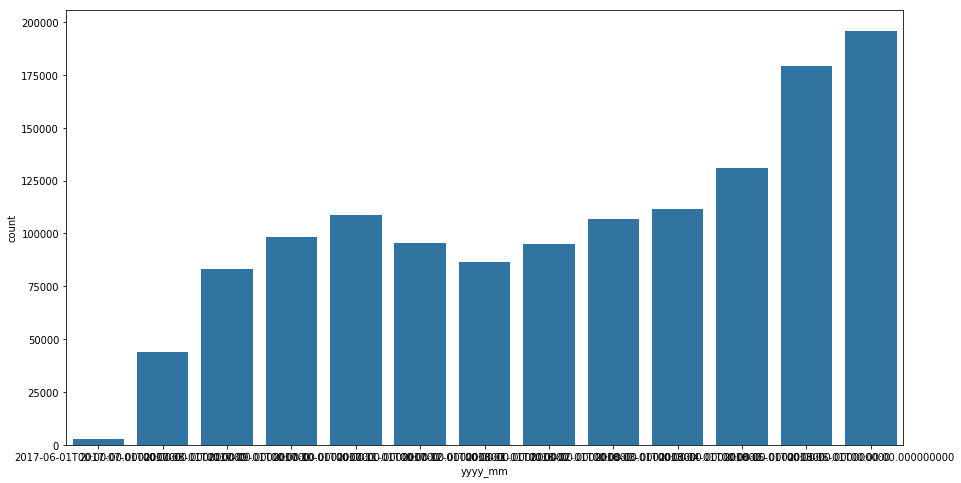

In [20]:
# Total rides by month
plt.figure(figsize=[15,8])
sb.countplot(data = df_clean, 
             x = 'yyyy_mm',
             color = sb.color_palette()[0]);

In its first 12 full months after launching (July 2017 - June 2018), Ford GoBike's ride volume had a compound monthly growth rate of 14.53%, which is very healthy.

Ride volume grew in 10 out of the first 12 months, with the two negative months being November 2017 and December 2017. This could be due to several factors. For example, weather and daylight are two major constraints in bike riding. November and December are both among the coldest months of the year, with the least daylight. Investigating the cause(s) of the decreases would be useful in helping anticipate and predict changes in ride volume going forwards.

### User Type

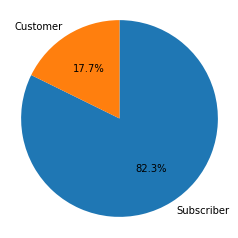

In [21]:
# Pie chart for user_type
type_counts = df_clean.user_type.value_counts()

plt.pie(type_counts, 
        labels = type_counts.index,
        autopct='%1.1f%%',
        startangle = 90,
        counterclock = False)

plt.axis('square');

Subscribers accounted for 82% of rides. This seems to be a strong indicator of the health of Ford GoBike's business, where only 18% of riders are "casual" users of GoBike and the rest are paying a monthly subscription.

For context, Ford GoBike subscribers pay \\$15 per month for unlimited rides, while non-subscriber users can either pay \\$2 per ride (up to 30 minutes) or \\$10 per day for unlimited 30-minute rides in 24 hours.

Source: https://www.fordgobike.com/pricing

### Gender

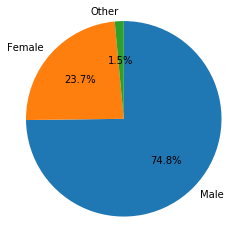

In [22]:
# Pie chart for member_gender
gender_counts = df_clean.member_gender.value_counts()

plt.pie(gender_counts, 
        labels = gender_counts.index,
        autopct='%1.1f%%',
        startangle = 90,
        counterclock = False)

plt.axis('square');

75% of Ford GoBike riders are male.

For reference, the Male:Female gender ratio in San Francisco County is 104:100. Notably, the ratio is higher at 110:100 for residents age 30-34 and 112:100 for those age 35-39.

Source: https://www.states101.com/gender-ratios/california/san-francisco-county

In other words, men outnumber women in San Francisco County, but the proportion of male Ford GoBike riders is still disproportionately high for the area, and for the core 30-39 age demographic.

### Age

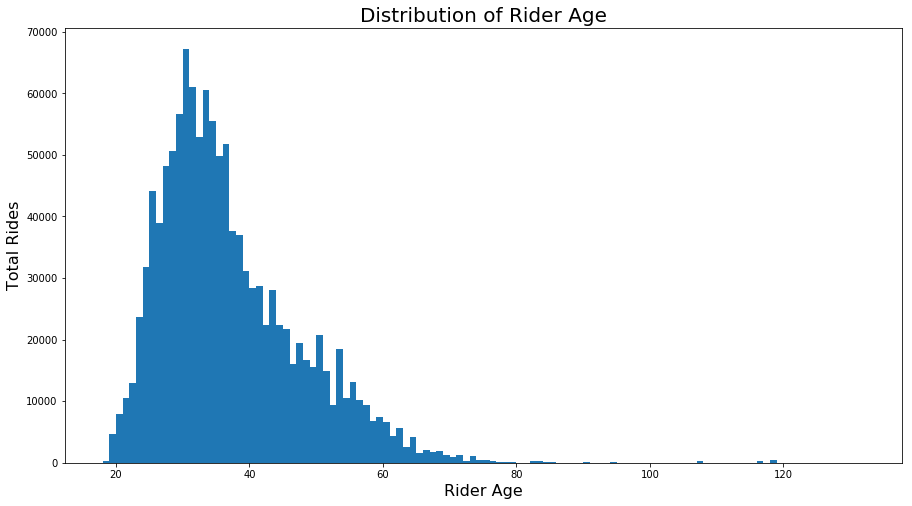

In [23]:
# Histogram for age
plt.figure(figsize=[15,8])
age_bins = np.arange(df_clean.age.min(), df_clean.age.max()+1, 1)
plt.hist(df_clean.age.dropna(), bins = age_bins)
plt.xlabel('Rider Age', fontsize=16)
plt.ylabel('Total Rides', fontsize=16)
plt.title('Distribution of Rider Age', fontsize=20);

In [24]:
df_clean.age.describe()

count    1.213625e+06
mean     3.653151e+01
std      1.056388e+01
min      1.800000e+01
25%      2.900000e+01
50%      3.400000e+01
75%      4.200000e+01
max      1.320000e+02
Name: age, dtype: float64

Rider age ranges from 18 to 132. The distribution skews right with a median of 34, and 50% of riders (the interquartile range) are between ages 29 and 42.

### Time of day

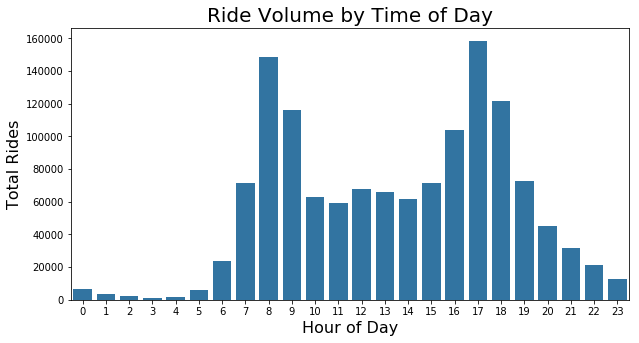

In [25]:
# Total rides by start_hour
plt.figure(figsize=[10,5])
sb.countplot(df_clean.start_hour, color = sb.color_palette()[0])
plt.xlabel('Hour of Day', fontsize=16)
plt.ylabel('Total Rides', fontsize=16)
plt.title('Ride Volume by Time of Day', fontsize=20);

The distribution of rides by hour of the day is clearly bimodal, with the first peak at 8am in the morning and the second peak at 5pm in the evening. This aligns with the start and end times of a typical workday, and would seem to indicate that Ford GoBike is commonly used by people as part of their work commute.

### Day of Week

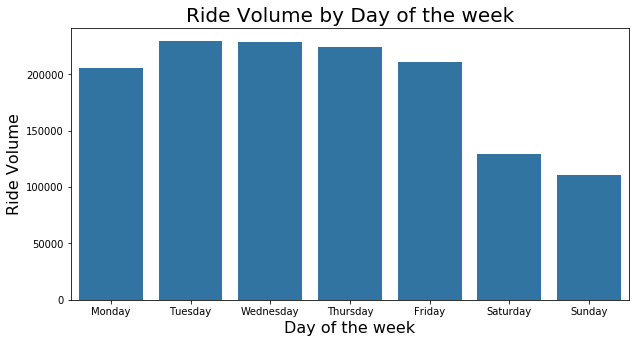

In [26]:
# Bar chart of start_dow

# The start_dow column is currently a string data type. Need to change to category.
dow_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
ordered_cat = pd.api.types.CategoricalDtype(categories=dow_order, ordered=True)
df_clean['start_dow'] = df_clean['start_dow'].astype(ordered_cat)

plt.figure(figsize=[10,5])
sb.countplot(df_clean.start_dow, color = sb.color_palette()[0])
plt.xlabel('Day of the week', fontsize=16)
plt.ylabel('Ride Volume', fontsize=16)
plt.title('Ride Volume by Day of the week', fontsize=20);

We can clearly see that more rides take place on weekdays (Mon-Fri) than on the weekend, by a factor of roughly 2x. This chart also indicates that Ford GoBike is commonly used during people's work commutes.

### Start and End Stations

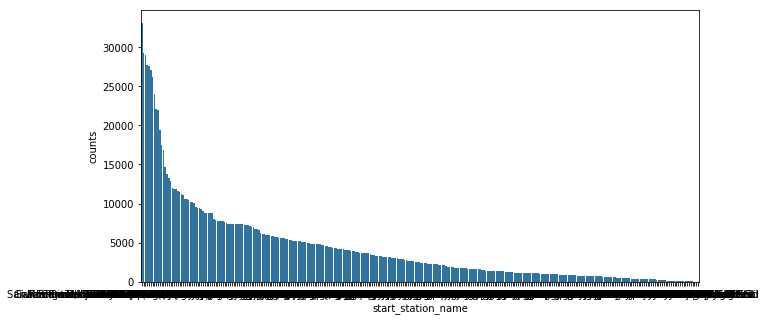

In [27]:
# Plot distribution of start stations
ride_start = df_clean.groupby('start_station_name').size().sort_values(ascending=False).reset_index(name='counts')

plt.figure(figsize=[10,5])
sb.barplot(data = ride_start, x = 'start_station_name', y = 'counts', color = sb.color_palette()[0]);

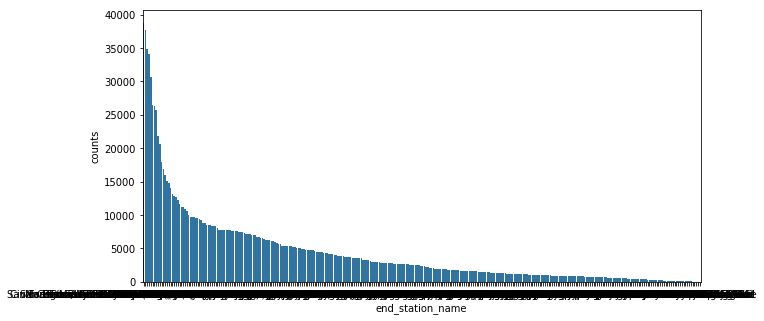

In [28]:
# Plot distribution of end stations
ride_end = df_clean.groupby('end_station_name').size().sort_values(ascending=False).reset_index(name='counts')

plt.figure(figsize=[10,5])
sb.barplot(data = ride_end, x = 'end_station_name', y = 'counts', color = sb.color_palette()[0]);

We can see in both charts that a few stations (on the left) account for a disproportionately large number of all rides, with a "long tail" of stations to the right.

Let's take a look at the top 10 most popular start and end stations.

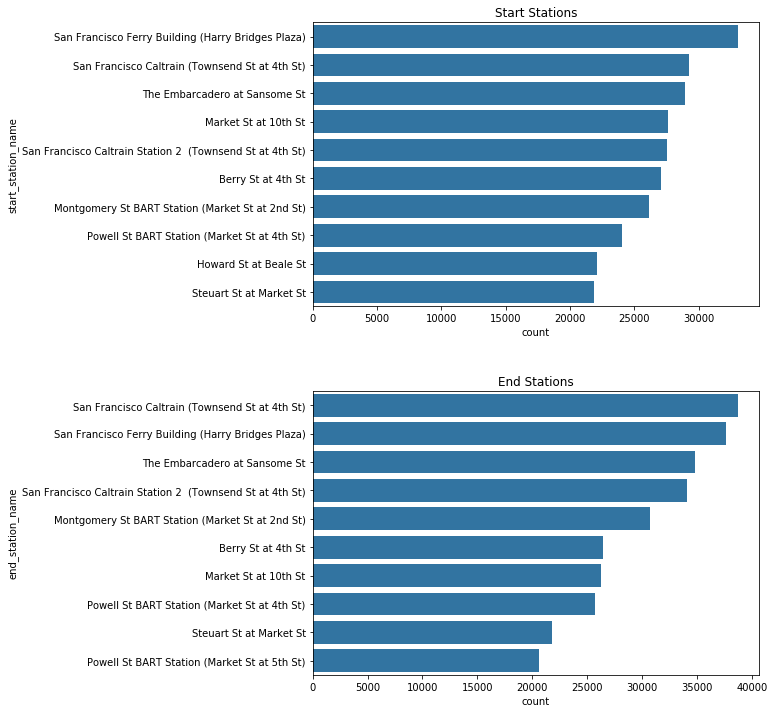

In [29]:
# Top 10 most popular start and end stations

plt.figure(figsize=[8,12])
plt.subplots_adjust(hspace=0.3)

plt.subplot(2, 1, 1)
sb.countplot(data = df_clean, 
             y = 'start_station_name', 
             order = df_clean.start_station_name.value_counts().iloc[:10].index,
             color = sb.color_palette()[0])
plt.title('Start Stations')

plt.subplot(2, 1, 2)
sb.countplot(data = df_clean, 
             y = 'end_station_name', 
             order = df_clean.end_station_name.value_counts().iloc[:10].index,
             color = sb.color_palette()[0])
plt.title('End Stations');

There is quite a bit of overlap between the two lists. Later on, we'll be looking at how the most popular stations differ based on user type (Subscribers vs Customers).

### Ride Duration

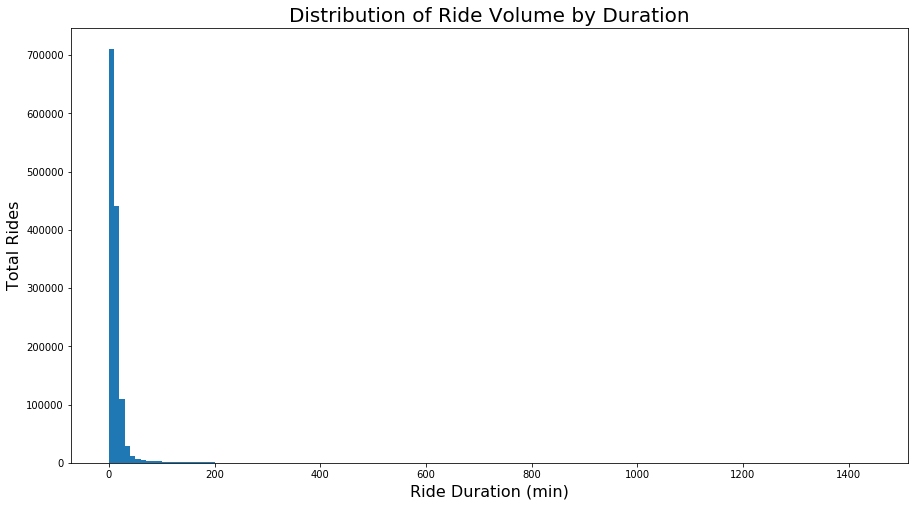

In [30]:
# Histogram of ride duration
plt.figure(figsize=[15,8])
duration_bins = np.arange(0, df_clean.duration_min.max()+10, 10)
plt.hist(df_clean.duration_min, bins = duration_bins)
plt.xlabel('Ride Duration (min)', fontsize=16)
plt.ylabel('Total Rides', fontsize=16)
plt.title('Distribution of Ride Volume by Duration', fontsize=20);

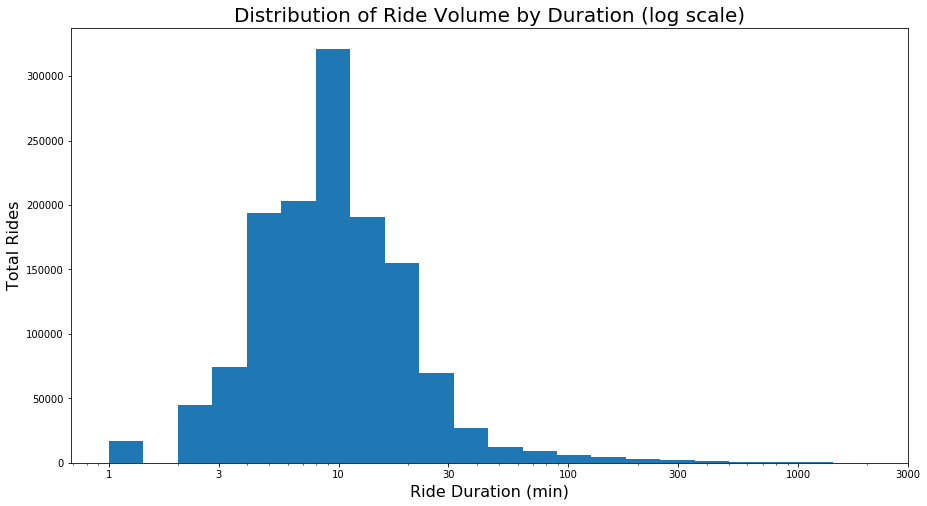

In [31]:
plt.figure(figsize=[15,8])
bin_edges = 10 ** np.arange(0, np.log10(df_clean.duration_min.max())+0.15, 0.15)
plt.hist(df_clean.duration_min, bins = bin_edges)
plt.xscale('log')

ticks = [1, 3, 10, 30, 100, 300, 1000, 3000]
plt.xticks(ticks, ticks)
plt.xlabel('Ride Duration (min)', fontsize=16)
plt.ylabel('Total Rides', fontsize=16)
plt.title('Distribution of Ride Volume by Duration (log scale)', fontsize=20);

In [32]:
# Percent of all rides that are 45 minutes or less
df_clean[df_clean.duration_min <= 45].count().duration_min * 1.0 / len(df_clean.duration_min)

0.969427790595453

The distribution for ride duration is highly skewed to the right. When plotted on a log-scale, ride duration follows an approximately log-normal distribution, with a median duration of 9 minutes and most rides taking between 3 and 30 minutes.

97% of all rides last 45 minutes or less.

### Discuss the distribution(s) of your variable(s) of interest. Were there any unusual points? Did you need to perform any transformations?

The distribution of ride distribution (in minutes) was extremely skewed to the right. After a log transformation, the data looked roughly normal with a mean of 9 minutes.

### Of the features you investigated, were there any unusual distributions? Did you perform any operations on the data to tidy, adjust, or change the form of the data? If so, why did you do this?

There was one row in which the ride end time was recorded as having occurred before its start time, which is obviously impossible. I removed that row from the dataset so that plots for ride duration would not display negative values.

## Bivariate Exploration



### Monthly Rides by User Type

Text(0.5,1,'Customers')

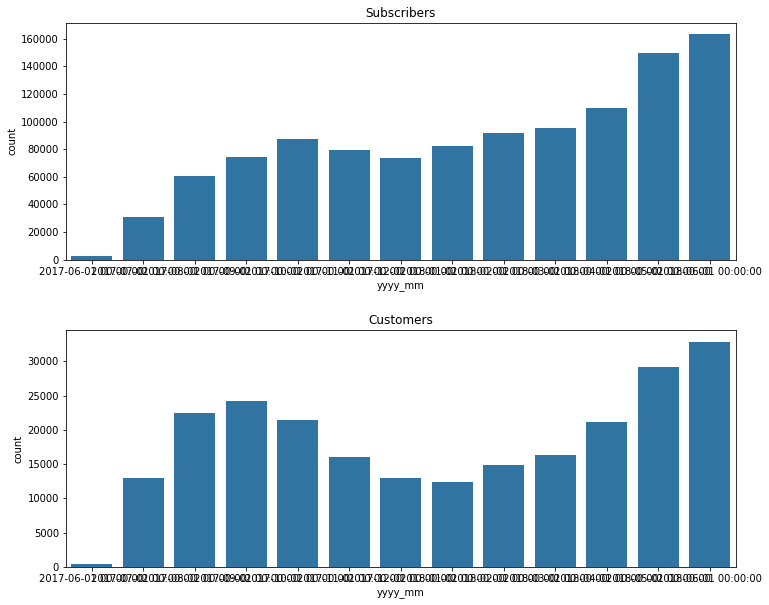

In [33]:
# Total rides by month
plt.figure(figsize=[12,10])
plt.subplots_adjust(hspace=0.3)

plt.subplot(2, 1, 1)
sb.countplot(data = df_clean.query('user_type == "Subscriber"'), 
             x = 'yyyy_mm',
             order = df_clean.groupby('yyyy_mm').count().index,
             color = sb.color_palette()[0])
plt.title('Subscribers')

plt.subplot(2, 1, 2)
sb.countplot(data = df_clean.query('user_type == "Customer"'), 
             x = 'yyyy_mm',
             order = df_clean.groupby('yyyy_mm').count().index,
             color = sb.color_palette()[0]);
plt.title('Customers')

Earlier in our univariate visualization of monthly ride totals, we hypothesized that the two months of decreasing ride volume in Nov 2017 and Dec 2017 may be due to cold weather and/or less daylight.

When we look at data for Customers only, we can see an even longer stretch of decreasing ride volume from October 2017 through January 2018. 

One possible explanation for this difference, is that if Subscribers are more likely to be using Ford GoBike for their work commute, there are simply less working days due to extended holiday breaks in November (Thanksgiving) and December (Christmas through New Year's Day).

Meanwhile, in the case of Customers, who are less likely to be using Ford GoBike for their work commute and may even be tourists, the four month stretch of decreasing ride volume may coincide with colder weather and less daylight, since Ford GoBike is not an essential part of their day like it is for many Subscribers.

These hypotheses would require further investigation in order to determine causality.

### Ride Duration by User Type

/Users/petershin/miniconda2/lib/python2.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


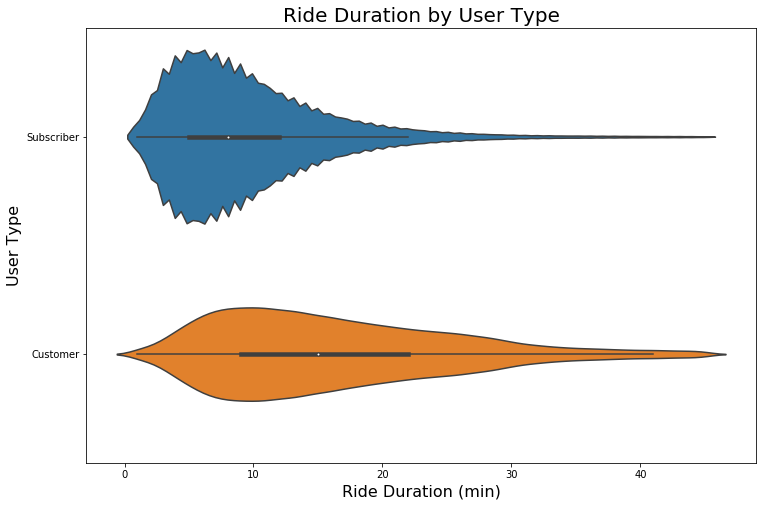

In [34]:
# Violin plot
plt.figure(figsize=[12,8])
sb.violinplot(data = df_clean.query('duration_min <= 45'), y = 'user_type', x = 'duration_min')
plt.xlabel('Ride Duration (min)', fontsize=16)
plt.ylabel('User Type', fontsize=16)
plt.title('Ride Duration by User Type', fontsize=20);

Subscribers tend to take shorter rides than customers. Most subscriber rides are 10 minutes or less, while the duration of customer rides tends to vary more i.e. has a wider spread.

This is a positive sign for the business. Earlier, we saw that 82% of Ford GoBike rides are by Subscibers, who pay a monthly fee for "unlimited 45-minute trips". The fact that average ride length or Subscribers is less than 10 minutes (and not the full 45 minutes) means there is more bike availability for other Subscribers and Customers.

NOTE: For this visualization, we looked at only rides taking 45 minutes or less, in order to exclude outliers. (Ford GoBike heavily disincentivizes rides longer than 45 minutes by charging an extra //$3 per additional 15 minutes.)

### Age by User Type

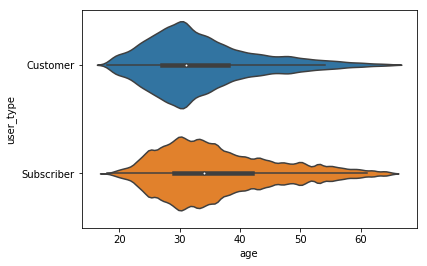

In [35]:
# Violin plot
sb.violinplot(data = df_clean.query('age <= 65'), y = 'user_type', x = 'age')

The age distributions for Customers and Subscribers look pretty similar. Subscribers tend to be slightly older, but not by much.

NOTE: This visualization includes only riders age 65 and younger, in order to exclude outliers. In our earlier univariate plot of Age, we saw that ride volume tails off after age 65.

### Day of Week by User Type

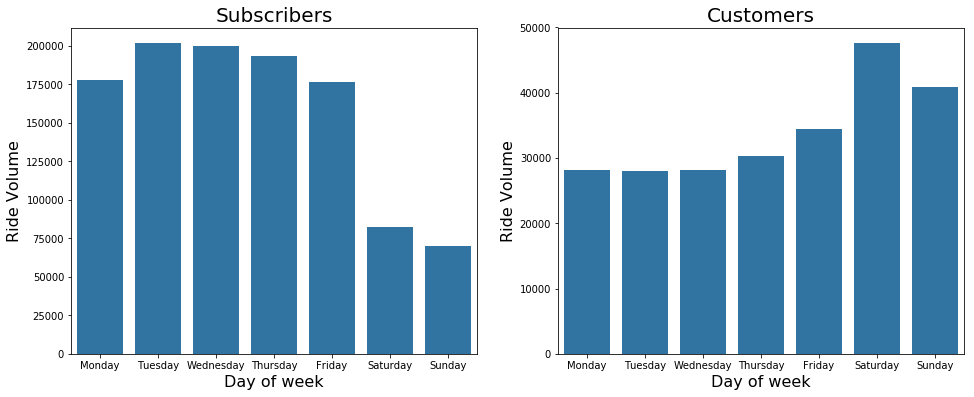

In [36]:
# The start_dow column is currently a string data type. Need to change to category.

plt.figure(figsize=[16, 6])

plt.subplot(1, 2, 1)
sb.countplot(data = df_clean.query('user_type == "Subscriber"'), x = 'start_dow', color = sb.color_palette()[0])
plt.xlabel('Day of week', fontsize=16)
plt.ylabel('Ride Volume', fontsize=16)
plt.title('Subscribers', fontsize=20)

plt.subplot(1, 2, 2)
sb.countplot(data = df_clean.query('user_type == "Customer"'), x = 'start_dow', color = sb.color_palette()[0])
plt.xlabel('Day of week', fontsize=16)
plt.ylabel('Ride Volume', fontsize=16)
plt.title('Customers', fontsize=20);

Subscriber usage is highest during the business week, while customer usage is highest during the weekend and peaks on Saturdays.

This further indicates that subscribers are more likely to be using Ford GoBike for their work commute, while customers are using Ford GoBike for leisure.

### Time of Day by User Type

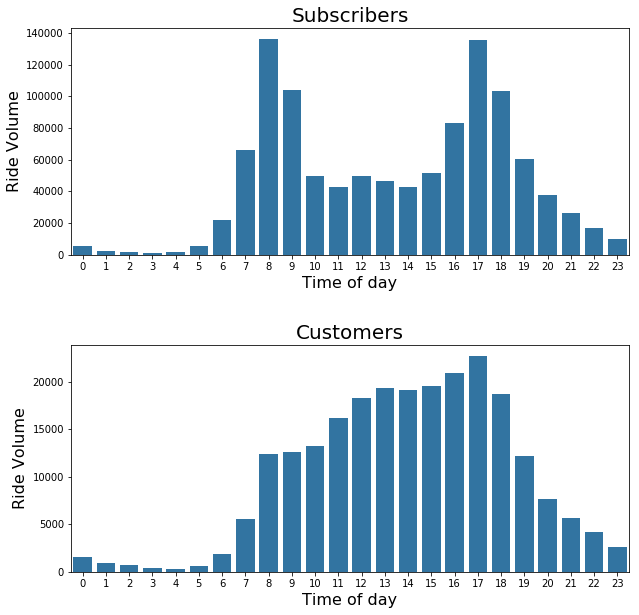

In [37]:
plt.figure(figsize=[10,10])
plt.subplots_adjust(hspace=0.4)

plt.subplot(2, 1, 1)
sb.countplot(data = df_clean.query('user_type == "Subscriber"'), x = 'start_hour', color = sb.color_palette()[0])
plt.xlabel('Time of day', fontsize=16)
plt.ylabel('Ride Volume', fontsize=16)
plt.title('Subscribers', fontsize=20)

plt.subplot(2, 1, 2)
sb.countplot(data = df_clean.query('user_type == "Customer"'), x = 'start_hour', color = sb.color_palette()[0])
plt.xlabel('Time of day', fontsize=16)
plt.ylabel('Ride Volume', fontsize=16)
plt.title('Customers', fontsize=20);

For subscribers, the distribution of rides by hour of the day is bimodal, which is what we saw in our univariate plot for Time of Day.

However, the distribution for Customers is notably NOT bimodal, and Customer rides are pretty evenly spread across daylight hours, from 8am to 7pm.

This would seem to indicate that Subscribers and Customers have different use cases. Subscribers tend to use Ford GoBike for their work commute, while Customers may be using Ford GoBike for non-work leisure purposes.

### Gender by User Type

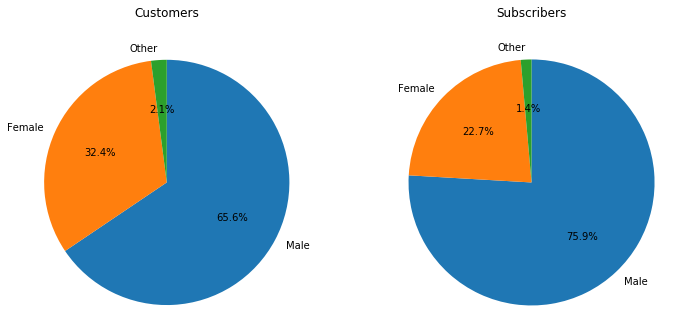

In [38]:
plt.figure(figsize = [12,5])

# Pie chart for customer gender
plt.subplot(1, 2, 1)
gender_customer = df_clean.query('user_type == "Customer"').member_gender.value_counts()

plt.pie(gender_customer, 
        labels = gender_customer.index,
        autopct='%1.1f%%',
        startangle = 90,
        counterclock = False)

plt.axis('square')
plt.title('Customers', pad = 30)

# Pie chart for subscriber gender 
plt.subplot(1, 2, 2)
gender_subscriber = df_clean.query('user_type == "Subscriber"').member_gender.value_counts()

plt.pie(gender_subscriber, 
        labels = gender_subscriber.index,
        autopct='%1.1f%%',
        startangle = 90,
        counterclock = False)

plt.axis('square')
plt.title('Subscribers', pad = 30);

The proportion of female Customers (32.4%) is greater than that of Subscribers (22.7%). It's unclear why that would be the case, and would require further investigation.

### Popular Stations by User Type

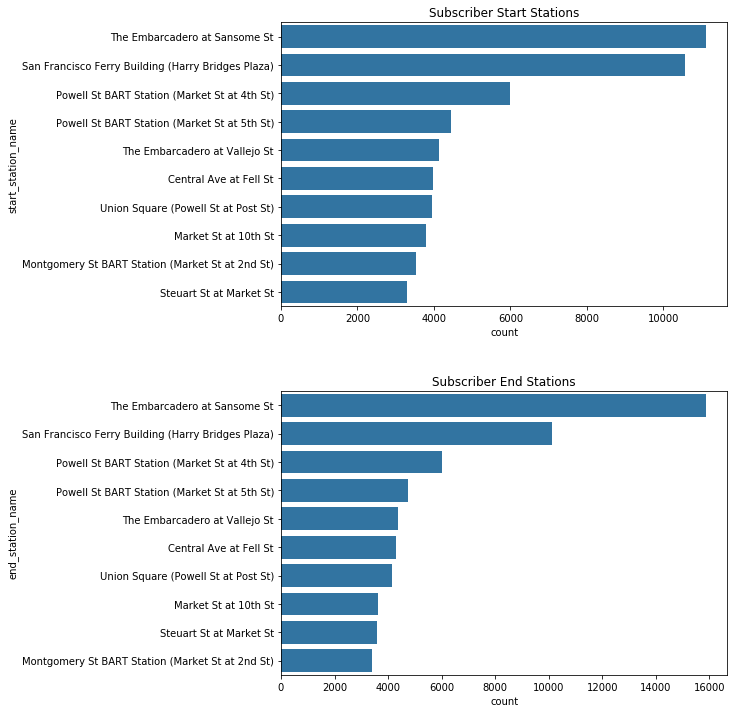

In [39]:
# Most popular start and end stations for Customers
plt.figure(figsize=[8,12])
plt.subplots_adjust(hspace=0.3)

customers = df_clean.query('user_type == "Customer"')

plt.subplot(2, 1, 1)
sb.countplot(data = customers, 
             y = 'start_station_name', 
             order = customers.start_station_name.value_counts().iloc[:10].index,
             color = sb.color_palette()[0])
plt.title('Subscriber Start Stations')

plt.subplot(2, 1, 2)
sb.countplot(data = customers, 
             y = 'end_station_name', 
             order = customers.end_station_name.value_counts().iloc[:10].index,
             color = sb.color_palette()[0])
plt.title('Subscriber End Stations');

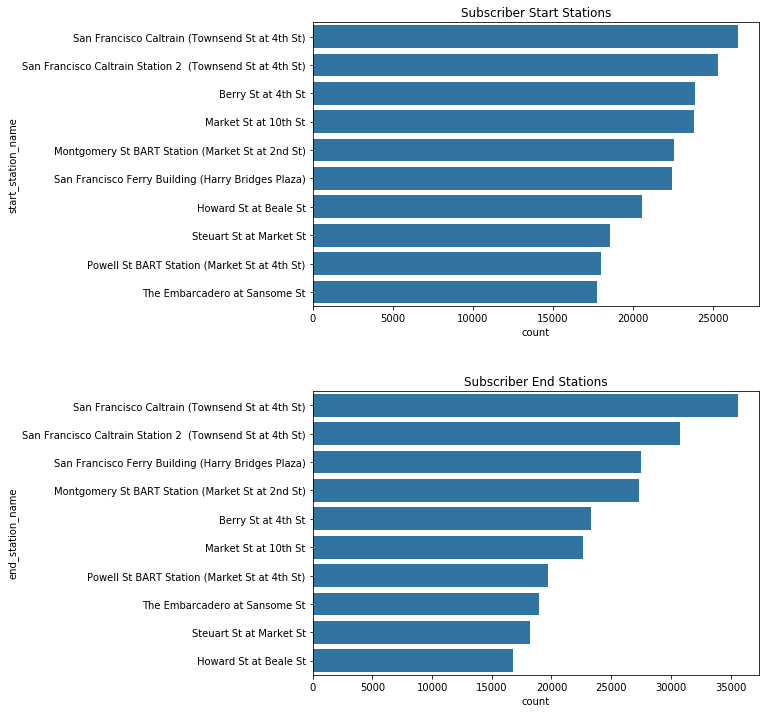

In [40]:
# Most popular start and end stations for Subscribers
plt.figure(figsize=[8,12])
plt.subplots_adjust(hspace=0.3)

subscribers = df_clean.query('user_type == "Subscriber"')

plt.subplot(2, 1, 1)
sb.countplot(data = subscribers, 
             y = 'start_station_name', 
             order = subscribers.start_station_name.value_counts().iloc[:10].index,
             color = sb.color_palette()[0])
plt.title('Subscriber Start Stations')

plt.subplot(2, 1, 2)
sb.countplot(data = subscribers, 
             y = 'end_station_name', 
             order = subscribers.end_station_name.value_counts().iloc[:10].index,
             color = sb.color_palette()[0])
plt.title('Subscriber End Stations');

We can see some clear differences when looking at stations by user type.

For Customers, the most popular stations are touristy areas such as The Embarcadero, the SF Ferry Building, Powell St BART, Union Square, etc.

For Subscribers, the top stations are at San Francisco Caltrain (a major commute hub) and other "downtown" areas.



### Ride Duration by Age

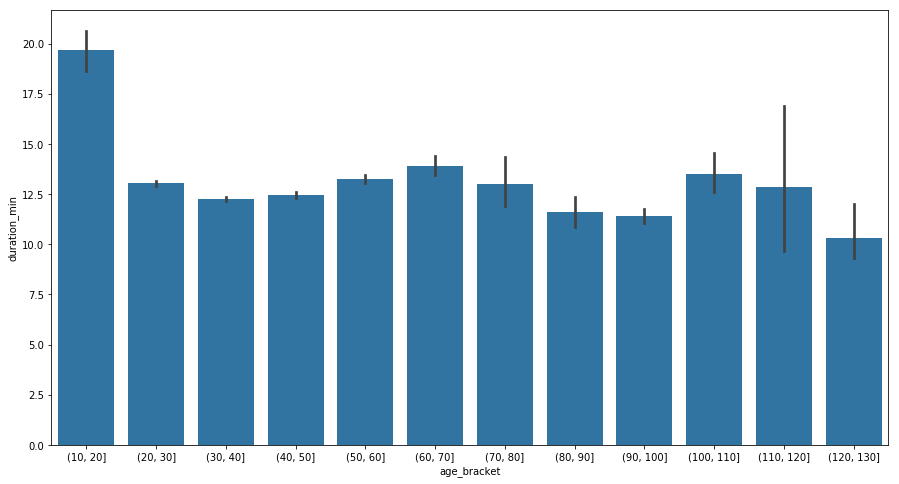

In [41]:
# Duration by age bracket

# Create new column
df_clean['age_bracket'] = pd.cut(df_clean['age'], np.arange(10, 140, 10))

plt.figure(figsize=[15,8])
sb.barplot(data = df_clean, x = 'age_bracket', y = 'duration_min', color = sb.color_palette()[0]);

Our main takeaway from this visualization is that riders age 20 and under stand out as having the longest average ride duration.

However, we saw in our univariate visualization for Age that riders age 20 and under account for a very small proportion of overall rides, so this has very little impact on the overall business.

### Ride Duration by Gender

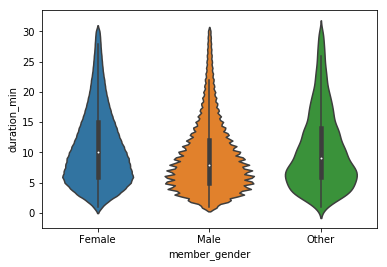

In [42]:
# Ride duration by gender
sb.violinplot(data = df_clean.query('duration_min <= 30'), x = 'member_gender', y = 'duration_min')

There seems to be no notable difference in ride duration based on gender.

### Ride Duration by Time of Day

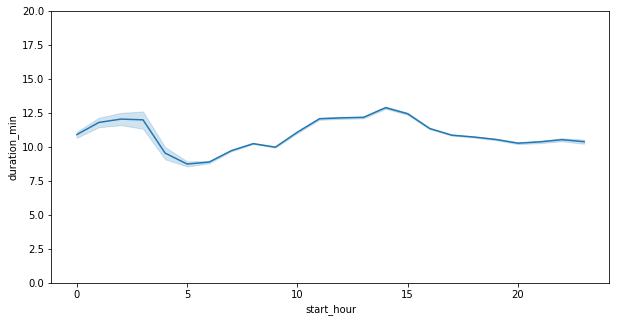

In [43]:
# Duration by start hour
plt.figure(figsize=[10,5])
sb.lineplot(data = df_clean.query('duration_min <= 60'), x = 'start_hour', y = 'duration_min')
plt.ylim(0,20);

Average ride duration is consistently between (appoximately) 8 and 13 minutes regardless of time of day.

### Ride Duration by Day of Week

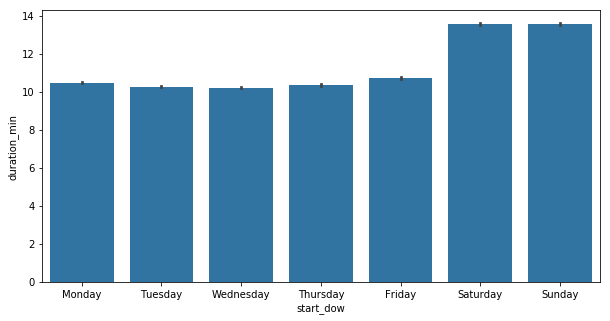

In [44]:
# Duration by day of week
plt.figure(figsize=[10,5])
sb.barplot(data = df_clean.query('duration_min <= 60'), 
           x = 'start_dow', 
           y = 'duration_min',
           order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
           color = sb.color_palette()[0]);

Rides on the weekend tend to be longer than rides on weekdays.

### Ride Duration by Month

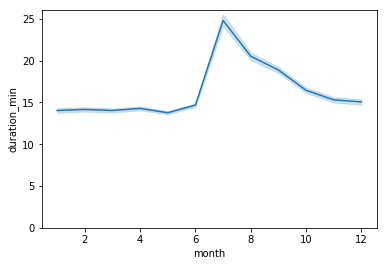

In [45]:
# Duration by start month
sb.lineplot(data = df_clean, x = 'month', y = 'duration_min', color = sb.color_palette()[0])
plt.ylim(0,26);

In the first half of 2017, average monthly ride furation was consistently around 15 minutes, but it jumped to almost 25 minutes in July before gradually returning back to around 15 minutes by November 2017.

### Talk about some of the relationships you observed in this part of the investigation. How did the feature(s) of interest vary with other features in the dataset?

The most notable differences were 1) ride duration by user type, 2) day of week by user type, and 3) time of day by user type.

Ride duration for subscribers tended to be shorter than that of customers, and with a much narrower spread.

Ride volume for subscribers is much higher on the weekdays than on the weekends, while ride volume for customers peaks during the weekend.

The distribution of rides by time of day for subscribers was bimodal, with peaks at 8am and 5pm. The distribution for customers was unimodeal and spread more evenly across daylight hours.


### Did you observe any interesting relationships between the other features (not the main feature(s) of interest)?

Average ride duration is higher on the weekends, and average ride duration spiked up in July 2017 before gradually returning to normal levels again by the end of the year.

## Multivariate Exploration

### Ride Duration by Month and User Type

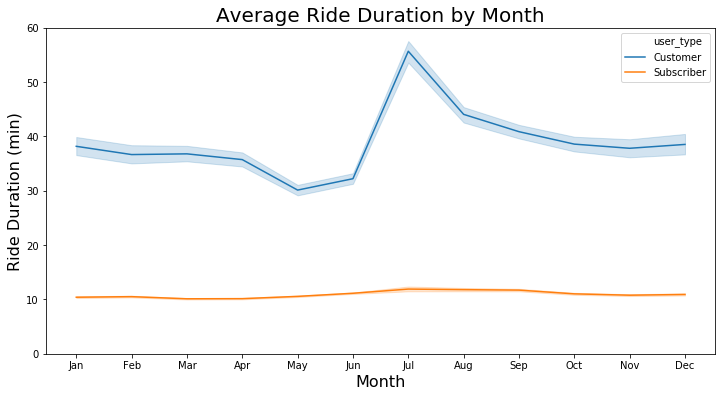

In [46]:
plt.figure(figsize=[12,6])
sb.lineplot(data = df_clean, 
            x = 'month', 
            y = 'duration_min',
            hue = 'user_type')
plt.ylim(0,60)
plt.xticks(np.arange(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.xlabel('Month', fontsize=16)
plt.ylabel('Ride Duration (min)', fontsize=16)
plt.title('Average Ride Duration by Month', fontsize=20);

### Ride Duration by Day of Week and User Type

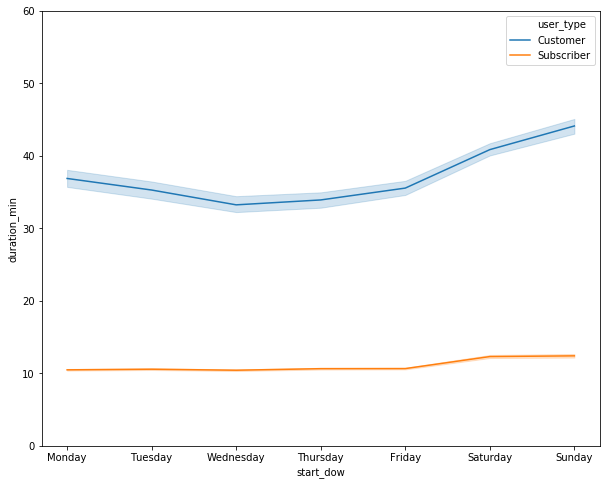

In [47]:
# Duration by day of week

plt.figure(figsize=[10,8])

dow_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
ordered_cat = pd.api.types.CategoricalDtype(categories=dow_order, ordered=True)
df_clean['start_dow'] = df_clean['start_dow'].astype(ordered_cat)

sb.lineplot(data = df_clean, 
            x = 'start_dow', 
            y = 'duration_min', 
            hue = 'user_type')
plt.ylim(0,60);

### Ride Duration by Time of Day and User Type

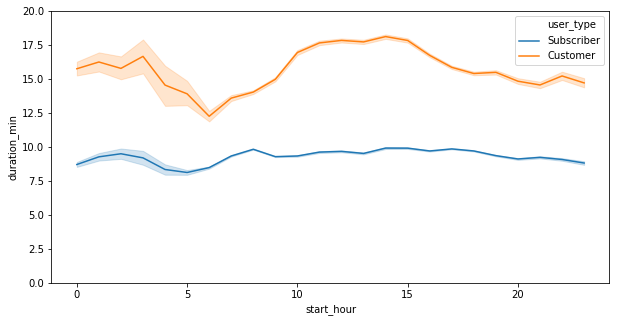

In [48]:
plt.figure(figsize=[10,5])
sb.lineplot(data = df_clean.query('duration_min <= 45'), x = 'start_hour', y = 'duration_min', hue = 'user_type')
plt.ylim(0, 20);

### Talk about some of the relationships you observed in this part of the investigation. Were there features that strengthened each other in terms of looking at your feature(s) of interest?

When looking at ride duration by month and user type, it became clear that the July 2017 spike in average ride duration was almost entirely attributably to customers, as ride duration for subscribers was remarkably consistent throughout the year at around 10 minutes.

Likewise, when looking at ride duration by day of week and by user type, it became clear that the higher ride duration during the weekend was being largely driven by customers.


### Were there any interesting or surprising interactions between features?

It was somewhat surprising that despite customer rides making up less than 20% of all rides, customers were still able to drive aggregate metric changes like the July 2017 ride duration spike and higher average ride duration on weekends, as mentioned above.